# Case Study: Predicting Bankruptcy in Polish Businesses

Data Mining CS5831, Spring 2025

Group 8: Kepha Barasa, Megan Berberich, Johnathon Hoffman, Devon Midkiff

This notebook includes all steps used to download, clean, and process data used to predict bankruptcy using a bankruptcy dataset from Polish companies. This [dataset](https://doi.org/10.24432/C5F600) is publically available on UC Irivine Machine Learning Repository. The GitHub repository had this data pre-downloaded for ease.

## 1. Set up environment

In [1]:
# === Standard Libraries ===
import os
import numpy as np
import pandas as pd

# === Visualization ===
import matplotlib.pyplot as plt
import seaborn as sns

# === Data Processing ===
from scipy.io import arff
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV,KFold
from sklearn.utils import resample

# === Classifiers ===
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb

# === Metrics ===
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    matthews_corrcoef,
    roc_auc_score,
    average_precision_score,
    cohen_kappa_score,
    precision_recall_curve,
    precision_recall_fscore_support
)

# === Imbalanced Learning ===
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# === Deep Learning ===
import tensorflow as tf
import keras
from keras import layers, regularizers, backend as K
from keras.models import Model, Sequential
from keras.regularizers import l2
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import (
    Conv1D, Dense, MaxPooling1D, Input, Flatten,
    LSTM, Dropout, Bidirectional, LeakyReLU, SimpleRNN
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping

# === Hyperparameter Tuning ===
import keras_tuner as kt
from keras_tuner import HyperParameters

# === Dataset Fetching ===
# from ucimlrepo import fetch_ucirepo

## 🧹 Data Preprocessing

Before training any models, the dataset must be cleaned and prepared to ensure high-quality inputs and meaningful results. This section outlines the key preprocessing steps applied to the Polish bankruptcy dataset, including:

- **Handling missing values**: Removing features or rows with excessive missing data.
- **Feature reduction**: Eliminating highly correlated or low-variance features to reduce redundancy and improve model efficiency.
- **Scaling numerical features**: Standardizing values to ensure consistent input ranges across models.
- **Class rebalancing**: Addressing class imbalance using techniques such as downsampling and SMOTE to create more balanced training sets.

These steps aim to enhance model performance, prevent overfitting, and support fair evaluation across all classification tasks.


### Get data and explore missing data

We have downloaded the data already, and it is stored in the GitHub repository and can be read in directly.

In [2]:
# reading the data file and then sepperating the class feature
data = pd.read_csv('../data/data.csv')
X = data.drop(columns=['class'])
y = data['class']

### Visualizing Missing Data with a Heatmap

This cell uses a heatmap to visualize the presence of missing values across the predictor features in the dataset `X`. Each column represents a feature, and each row represents a sample.

- **White/bright areas** indicate missing values.
- **Darker areas** represent non-missing entries.

This visualization provides an intuitive overview of missing data patterns, helping to inform threshold decisions for column or row removal during preprocessing.


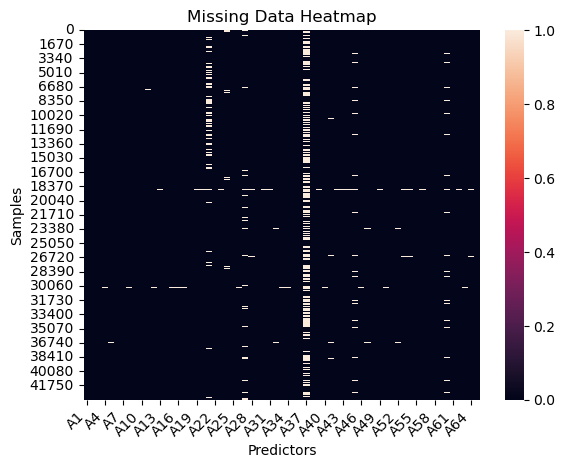

In [3]:
# Visualizing missing data
sns.heatmap(X.isnull(), cbar=True)
plt.title('Missing Data Heatmap')
plt.xlabel('Predictors')
plt.ylabel('Samples')
plt.xticks(rotation=45, ha='right')
plt.show()

### Handling Missing Data: Column and Row Removal

This cell performs a two-step cleanup process to handle missing values in the dataset:

1. **Column Removal**:
   - Counts missing values for each feature.
   - Drops any columns with more than 1,000 missing values, assuming they lack sufficient data to be useful.

2. **Row Removal**:
   - Removes any remaining rows with missing values across the retained features.

Summary statistics are printed to assess the proportion of missing values before removal, and the shape of the cleaned dataset (`combined_dataset`) is displayed afterward to confirm the reduction in dimensionality and size.


In [ ]:
# Assuming X and y are DataFrames or Series
full_dataset = pd.concat([X, y], axis=1)

# Count the number of missing values
missing_counts = full_dataset.isnull().sum()
# Sort by highest missing values and get top results
top_missing = missing_counts.sort_values(ascending=False)
top_missing.head(20)
missing_counts = full_dataset.isnull().sum()

# Select columns to drop based on missing over 1000 values
columns_to_drop = missing_counts[missing_counts > 1000].index
# Delete missing columns
combined_dataset = full_dataset.drop(columns=columns_to_drop)
print(100 * missing_counts/len(full_dataset))
print(100 * top_missing/len(full_dataset) )
print(columns_to_drop)
combined_dataset = combined_dataset.dropna()
print(f"Removed rows with missing values. New dataset shape: {combined_dataset.shape}")

A1       0.018431
A2       0.018431
A3       0.018431
A4       0.308720
A5       0.205046
           ...   
A62      0.292593
A63      0.308720
A64      1.870752
year     0.000000
class    0.000000
Length: 66, dtype: float64
A37      43.736897
A21      13.486925
A27       6.367930
A60       4.957954
A45       4.946435
           ...    
A57       0.016127
A59       0.016127
A55       0.002304
year      0.000000
class     0.000000
Length: 66, dtype: float64
Index(['A21', 'A27', 'A37', 'A45', 'A60'], dtype='object')
Removed rows with missing values. New dataset shape: (40506, 61)


### Verifying Class Distribution after Data Removal

This cell verifies that the process of removing certain columns and rows did not disproportionately affect the distribution of class labels in the dataset. The steps include:

- Calculating class counts from the updated dataset (`combined_dataset`).
- Visualizing these counts as a bar chart to confirm that class proportions are maintained post-cleaning.
  
This check ensures that our data reduction and cleaning steps did not introduce bias or unintended class imbalance.


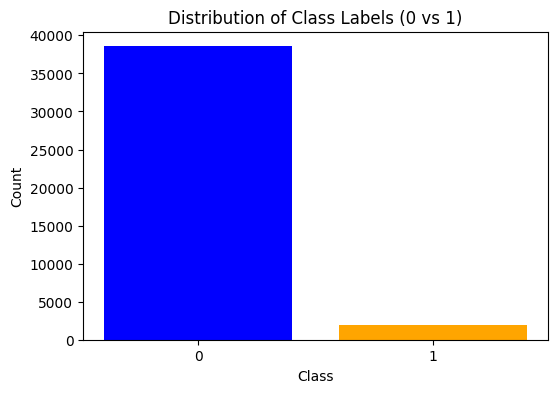

In [ ]:
###I ran this code here to check to make sure removing certain columns and rows wouldnt affect class counts too much
#It evenly removed from both 0 and 1
# class_counts = copy_dataset['class'].value_counts()
# class_counts
class_counts = combined_dataset['class'].value_counts()
class_counts
# Plot bar chart
plt.figure(figsize=(6, 4))
plt.bar(class_counts.index.astype(str), class_counts.values, color=['blue', 'orange'])
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Distribution of Class Labels (0 vs 1)")
plt.xticks([0, 1], labels=['0', '1'])
plt.show()

### Class Rebalancing via Downsampling (7:1 Ratio) and Visualization

This cell addresses the original class imbalance in the dataset by:

- Splitting the dataset into majority (`class = 0`) and minority (`class = 1`) groups.
- Downsampling the majority class to a size 7× larger than the minority class (controlled imbalance).
- Combining the resampled majority set with the full minority class to create a partially balanced dataset.
- Shuffling the final `combined_dataset` to randomize row order.

The resulting class distribution is displayed in a bar plot to visually confirm the new 7:1 ratio between majority and minority classes.


In [ ]:
# Separate majority and minority classes
majority = combined_dataset[combined_dataset['class'] == 0]
minority = combined_dataset[combined_dataset['class'] == 1]

# Desired number of majority samples (2x minority)
desired_majority_size = 7 * len(minority)

# Downsample majority class
majority_downsampled = resample(majority,
                                   replace=False,
                                   n_samples=desired_majority_size,
                                   random_state=42)

# Combine minority class with downsampled majority class
df_resampled = pd.concat([majority_downsampled, minority])

# Shuffle the result
combined_dataset = df_resampled.sample(frac=1, random_state=42).reset_index(drop=True)

class_counts = combined_dataset['class'].value_counts()
class_counts
# Plot bar chart
plt.figure(figsize=(6, 4))
plt.bar(class_counts.index.astype(str), class_counts.values, color=['blue', 'orange'])
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Distribution of Class Labels (0 vs 1)")
plt.xticks([0, 1], labels=['0', '1'])
plt.show()

### Identifying Highly Correlated Feature Pairs

This cell computes the Pearson correlation matrix for all numeric features (excluding `class` and `year`) and identifies feature pairs with a high absolute correlation (greater than 0.8 but less than 1). The steps include:

- Computing the correlation matrix for predictor variables.
- Applying a threshold to filter for strong linear relationships.
- Iterating through only the upper triangle of the matrix to avoid duplicate pairings.
- Storing and printing each highly correlated pair along with their correlation coefficient.

These pairs inform later feature reduction decisions to mitigate multicollinearity and improve model generalizability.


In [ ]:
# Compute the correlation matrix after dropping non-numeric or irrelevant columns
correlation_matrix = combined_dataset.drop(columns=['class', 'year']).corr()

# Set a threshold for identifying high correlations (ignoring perfect correlation of 1)
threshold = 0.8
highly_correlated = (correlation_matrix.abs() > threshold) & (correlation_matrix.abs() < 1)

# Initialize a list to store the pairs of highly correlated columns
correlated_pairs = []

# Iterate through the upper triangle of the correlation matrix to avoid duplicates
for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        if highly_correlated.iloc[i, j]:
            # Append the column names and their correlation value
            correlated_pairs.append((
                correlation_matrix.columns[i],
                correlation_matrix.columns[j],
                correlation_matrix.iloc[i, j]
            ))

# Print the pairs of columns that are highly correlated
print("Highly correlated columns (above threshold of 0.8):")
for col1, col2, corr in correlated_pairs:
    print(f"{col1} <--> {col2} (Correlation: {corr:.2f})")


Highly correlated columns (above threshold of 0.8):
A2 <--> A3 (Correlation: -0.94)
A2 <--> A10 (Correlation: -0.99)
A2 <--> A25 (Correlation: -0.92)
A2 <--> A38 (Correlation: -0.95)
A2 <--> A51 (Correlation: 0.96)
A3 <--> A10 (Correlation: 0.93)
A3 <--> A25 (Correlation: 0.87)
A3 <--> A38 (Correlation: 0.94)
A3 <--> A51 (Correlation: -0.95)
A4 <--> A40 (Correlation: 0.96)
A4 <--> A46 (Correlation: 1.00)
A4 <--> A50 (Correlation: 0.84)
A7 <--> A9 (Correlation: 1.00)
A7 <--> A11 (Correlation: 1.00)
A7 <--> A14 (Correlation: 1.00)
A7 <--> A16 (Correlation: 0.88)
A7 <--> A18 (Correlation: 1.00)
A7 <--> A22 (Correlation: 1.00)
A7 <--> A24 (Correlation: 0.91)
A7 <--> A33 (Correlation: 0.99)
A7 <--> A34 (Correlation: 1.00)
A7 <--> A35 (Correlation: 1.00)
A7 <--> A36 (Correlation: 1.00)
A7 <--> A48 (Correlation: 1.00)
A7 <--> A63 (Correlation: 0.99)
A8 <--> A17 (Correlation: 1.00)
A9 <--> A11 (Correlation: 1.00)
A9 <--> A14 (Correlation: 1.00)
A9 <--> A16 (Correlation: 0.88)
A9 <--> A18 (Corr

### Visualizing Feature Correlation with a Heatmap

This cell generates a heatmap of the feature-to-feature correlation matrix to visualize the strength and direction of linear relationships between numerical variables. Key details:

- Darker or brighter colors indicate stronger positive or negative correlations.
- Highly correlated features can signal redundancy, which may impact model performance due to multicollinearity.
- This visualization supports feature selection decisions made later in the pipeline.

The heatmap provides an intuitive overview of the correlation structure in the dataset.


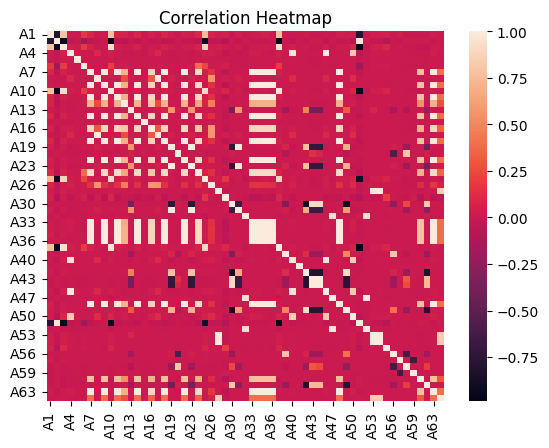

In [ ]:
# Create a heatmap to visualize the correlation matrix
sns.heatmap(correlation_matrix)

# Set the title of the heatmap plot
plt.title("Correlation Heatmap")

# Display the plot
plt.show()

### Removing Highly Correlated Features

This cell removes redundant features based on high pairwise correlation. The steps include:

- Iterating through a list of highly correlated feature pairs (e.g., with $|r| \geq 0.8$).
- For each pair, one feature is arbitrarily selected for removal (to avoid multicollinearity).
- The selected columns are dropped from the `combined_dataset`.
- The `year` column is also dropped, assuming it is non-predictive or a potential data leak.

A summary is printed to indicate the number of dropped columns and the shape of the resulting `reduced_dataset`.


In [ ]:
# Initialize an empty set to store names of columns to drop
columns_to_drop = set()

# Iterate through the list of correlated column pairs
for col1, col2, corr in correlated_pairs:
    # If neither column has been marked for dropping yet
    if col1 not in columns_to_drop and col2 not in columns_to_drop:
        columns_to_drop.add(col1)  # Arbitrarily choose to drop col1 to reduce redundancy

# Drop the selected highly correlated columns from the dataset
reduced_dataset = combined_dataset.drop(columns=columns_to_drop)

# Also drop the 'year' column explicitly (assuming it's not needed)
reduced_dataset = reduced_dataset.drop(columns=['year'])

# Print how many columns were dropped due to high correlation
print(f"Dropped {len(columns_to_drop)} highly correlated columns.")

# Print the shape of the reduced dataset
print("Remaining dataset shape:", reduced_dataset.shape)

Dropped 36 highly correlated columns.
Remaining dataset shape: (15616, 24)


### Visualizing Raw Distributions of Numerical Features

This cell plots histograms for all numerical features in the original `combined_dataset` before any scaling or transformation. Each subplot displays the distribution of values for a single feature, allowing for:

- Inspection of skewness, outliers, and non-normality
- Identification of potential candidates for transformation or normalization
- Visual understanding of value ranges and variability

The plots are arranged in a grid layout with 4 plots per row for clear side-by-side comparison.


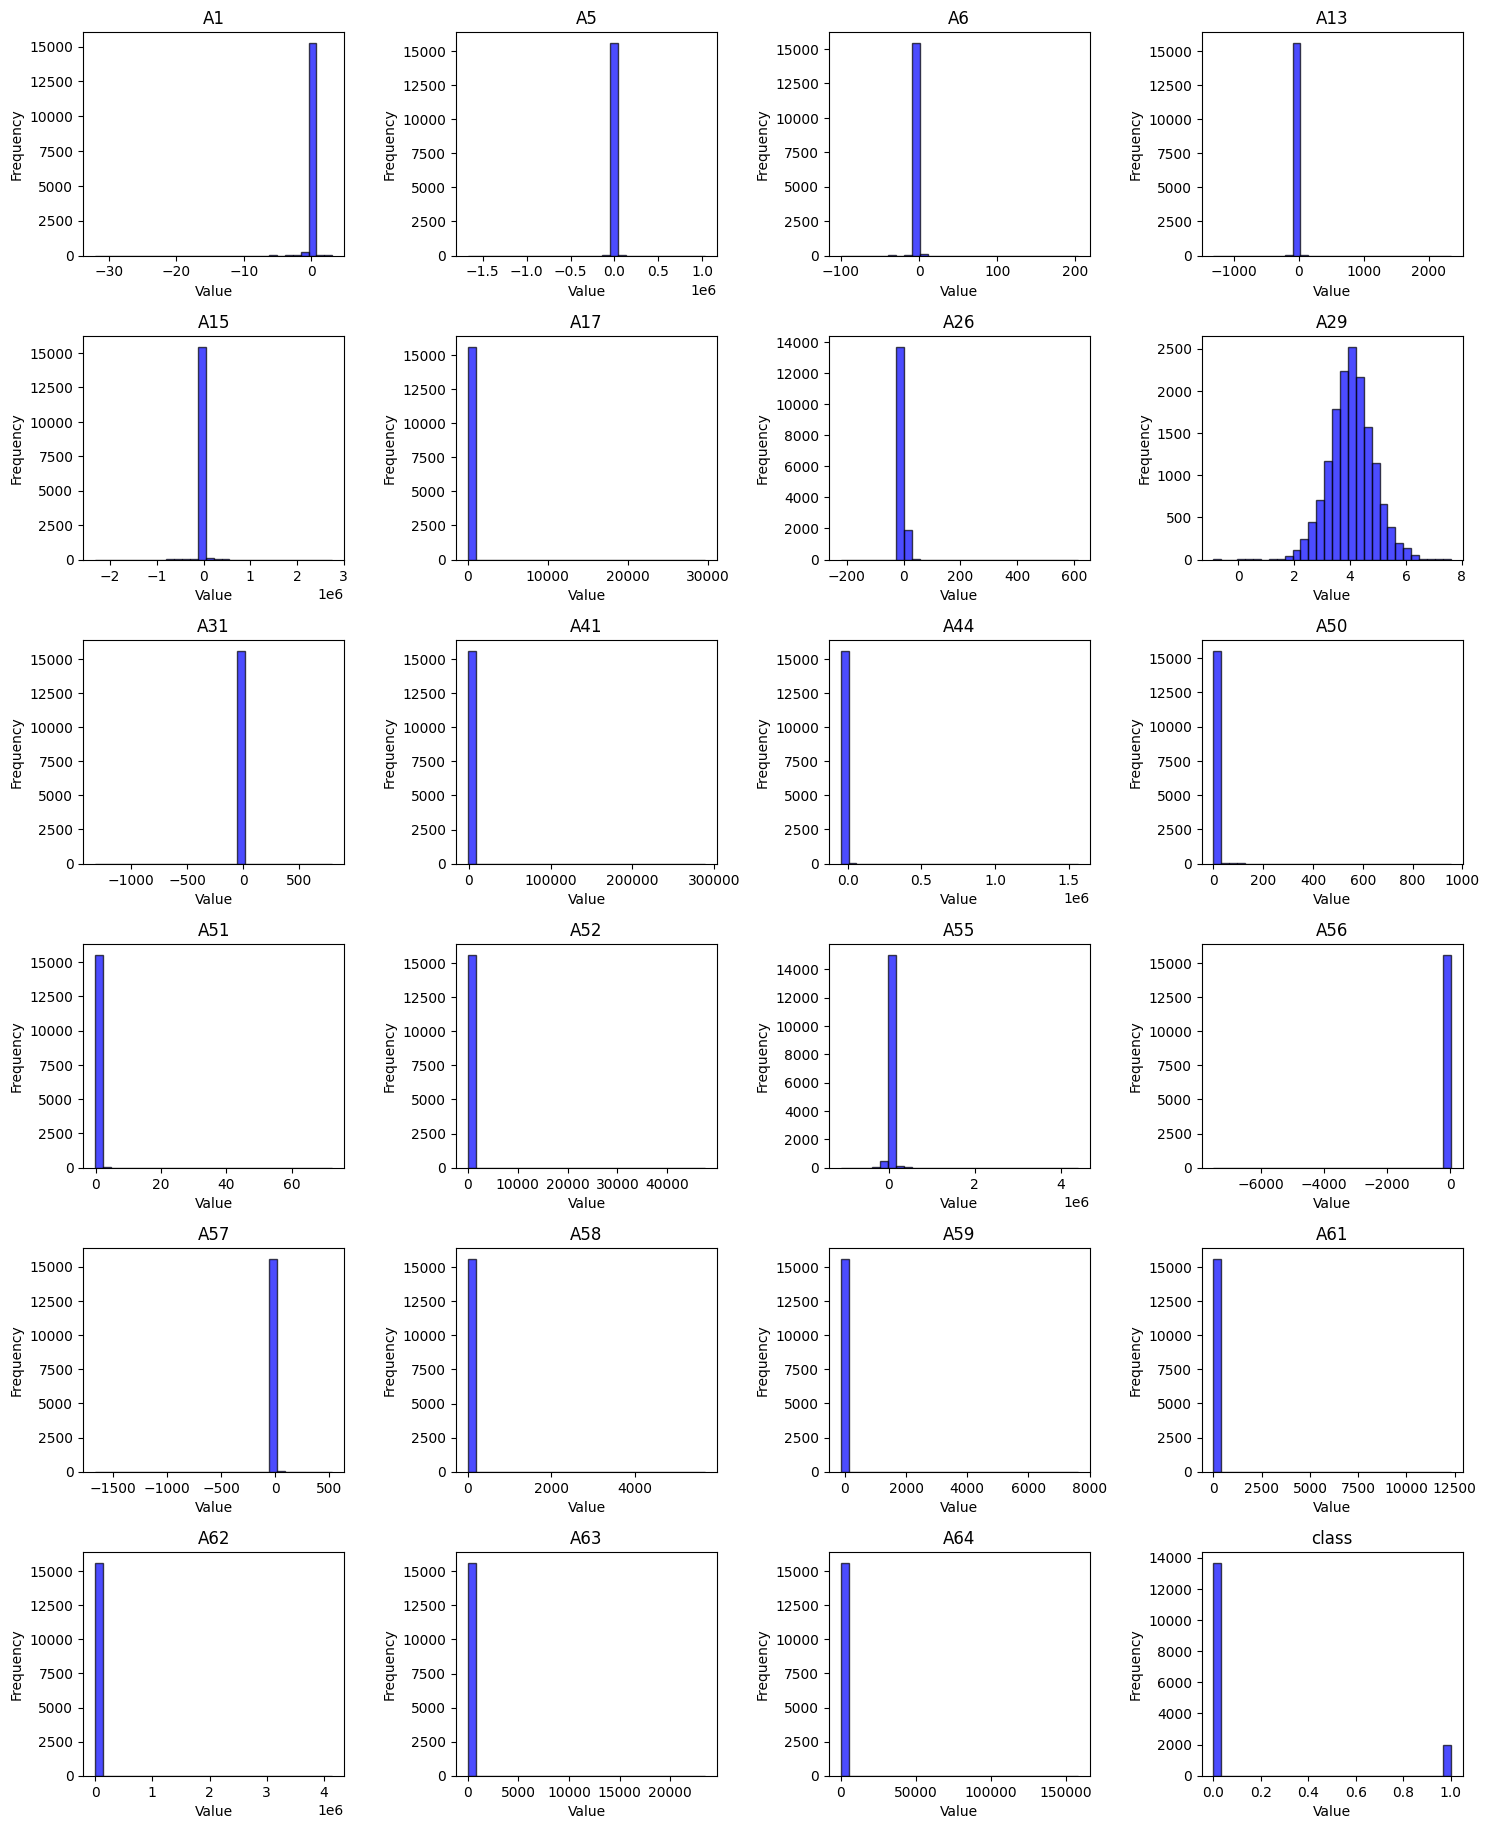

In [ ]:
numerical_cols = reduced_dataset.select_dtypes(include=['int64', 'float64']).columns

num_cols = len(numerical_cols)
num_rows = (num_cols // 4) + 1  # Create a grid with 4 plots per row

plt.figure(figsize=(15, num_rows * 3))

for i, col in enumerate(numerical_cols, 1):
    plt.subplot(num_rows, 4, i)
    plt.hist(combined_dataset[col], bins=30, alpha=0.7, color='blue', edgecolor='black')
    plt.title(col)
    plt.xlabel("Value")
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


### Correlation of Features with Target Variable

This cell computes the Pearson correlation coefficients between each feature and the target variable (`class`) in the `combined_dataset`. The results are sorted in descending order to highlight which features are most positively or negatively correlated with bankruptcy.

This helps identify potentially informative features for model training and offers early insights into feature importance.


In [ ]:
correlation = combined_dataset.corr()['class'].sort_values(ascending=False)
print(correlation)

class    1.000000
A2       0.129227
A51      0.123470
year     0.077212
A15      0.017593
           ...   
A3      -0.125879
A10     -0.128118
A38     -0.129971
A1      -0.135804
A25     -0.137417
Name: class, Length: 61, dtype: float64


### Standardizing Numerical Features

This cell applies `StandardScaler` to normalize all numerical features in the dataset (excluding the target variable `class`). Standardization transforms each feature to have a mean of 0 and a standard deviation of 1, which is essential for many machine learning algorithms that are sensitive to feature scale (e.g., SVM, logistic regression, neural networks).

A print statement confirms completion, but the transformation is not run immediately to allow further inspection or modification before execution.


In [ ]:
scaler = StandardScaler()

# Select numerical columns excluding 'class'
numerical_cols = reduced_dataset.select_dtypes(include=['int64', 'float64']).columns
numerical_cols = numerical_cols.drop('class', errors='ignore')  # Exclude class column
# Apply standardization
scaled_dataset = scaler.fit_transform(reduced_dataset[numerical_cols])
#dont run yet
print("All numerical features have been scaled using StandardScaler.")
scaled_dataset

All numerical features have been scaled using StandardScaler.


array([[-7.55679062e-01,  9.23413290e-03, -3.29537531e-02, ...,
        -1.79417443e-02, -2.20500515e-02, -2.98184346e-02],
       [-7.40691816e-02,  1.16015491e-02,  1.20926865e-01, ...,
        -1.83044018e-02, -1.35646711e-02,  3.65184243e-02],
       [ 4.42623244e-02,  8.77289370e-03,  3.49423861e-04, ...,
        -1.72400958e-02, -3.05816434e-02, -2.95632052e-02],
       ...,
       [ 9.95054396e-03,  8.97743617e-03,  3.49423861e-04, ...,
        -1.82323289e-02, -1.56516231e-02,  2.03381958e-02],
       [ 1.78465751e-01,  2.37107589e-02,  3.49423861e-04, ...,
        -1.86380703e-02,  8.92080063e-04, -3.16661293e-02],
       [ 5.42102186e-02,  9.01482018e-03,  3.49423861e-04, ...,
        -1.75252740e-02, -2.78620723e-02, -3.12143352e-02]])

### Reconstructing the Scaled Dataset with Class Labels

This cell rebuilds the `scaled_dataset` as a DataFrame using the original column names for numerical features. After scaling, the target variable (`class`) is reattached to ensure proper alignment between features and labels. A preview of the reconstructed dataset is displayed to verify correctness.


In [ ]:
scaled_dataset = pd.DataFrame(scaled_dataset, columns=numerical_cols)

# Re-add the class column
scaled_dataset['class'] = reduced_dataset['class'].values  # Ensure correct alignment

# Display a preview
scaled_dataset.head()

,A1,A5,A6,A13,A15,A17,A26,A29,A31,A41,...,A55,A56,A57,A58,A59,A61,A62,A63,A64,class
0,-0.755679,0.009234,-0.032954,-0.008411,-0.051819,-0.019480,-0.124128,0.868665,-0.000947,-0.008285,...,0.052161,0.011116,-0.008196,-0.007153,-0.015369,-0.042931,-0.017942,-0.022050,-0.029818,0
1,-0.074069,0.011602,0.120927,-0.003686,0.061858,-0.019647,-0.075891,-2.904975,0.009050,-0.008155,...,-0.111828,0.012897,0.016431,-0.009888,-0.018681,-0.066959,-0.018304,-0.013565,0.036518,0
2,0.044262,0.008773,0.000349,-0.001712,0.016264,-0.020336,-0.068971,0.094378,0.011873,-0.008159,...,-0.073617,0.013212,0.022439,-0.010737,-0.011066,-0.050963,-0.017240,-0.030582,-0.029563,0
3,0.821826,0.010391,0.562687,0.002282,-0.025802,-0.016580,0.034850,1.194268,0.018187,-0.008232,...,0.558081,0.014627,0.039274,-0.012988,-0.018666,0.037883,-0.018471,-0.007584,-0.022905,0
4,0.606274,0.011366,0.000349,0.007022,-0.024139,-0.017140,0.029138,-2.400206,0.021579,-0.008228,...,-0.111875,0.015232,0.033843,-0.013950,-0.018681,-0.081103,-0.017254,-0.030467,-0.030805,0


### Distribution of Numerical Features

This cell generates histograms for all numerical features in the scaled dataset to visualize their distributions. Each subplot represents the distribution of a single variable, helping to:

- Identify skewed, normal, or uniform distributions
- Spot potential outliers or artifacts
- Verify the impact of scaling and transformation

The plots are arranged in a grid layout (4 plots per row) for easy comparison across features.


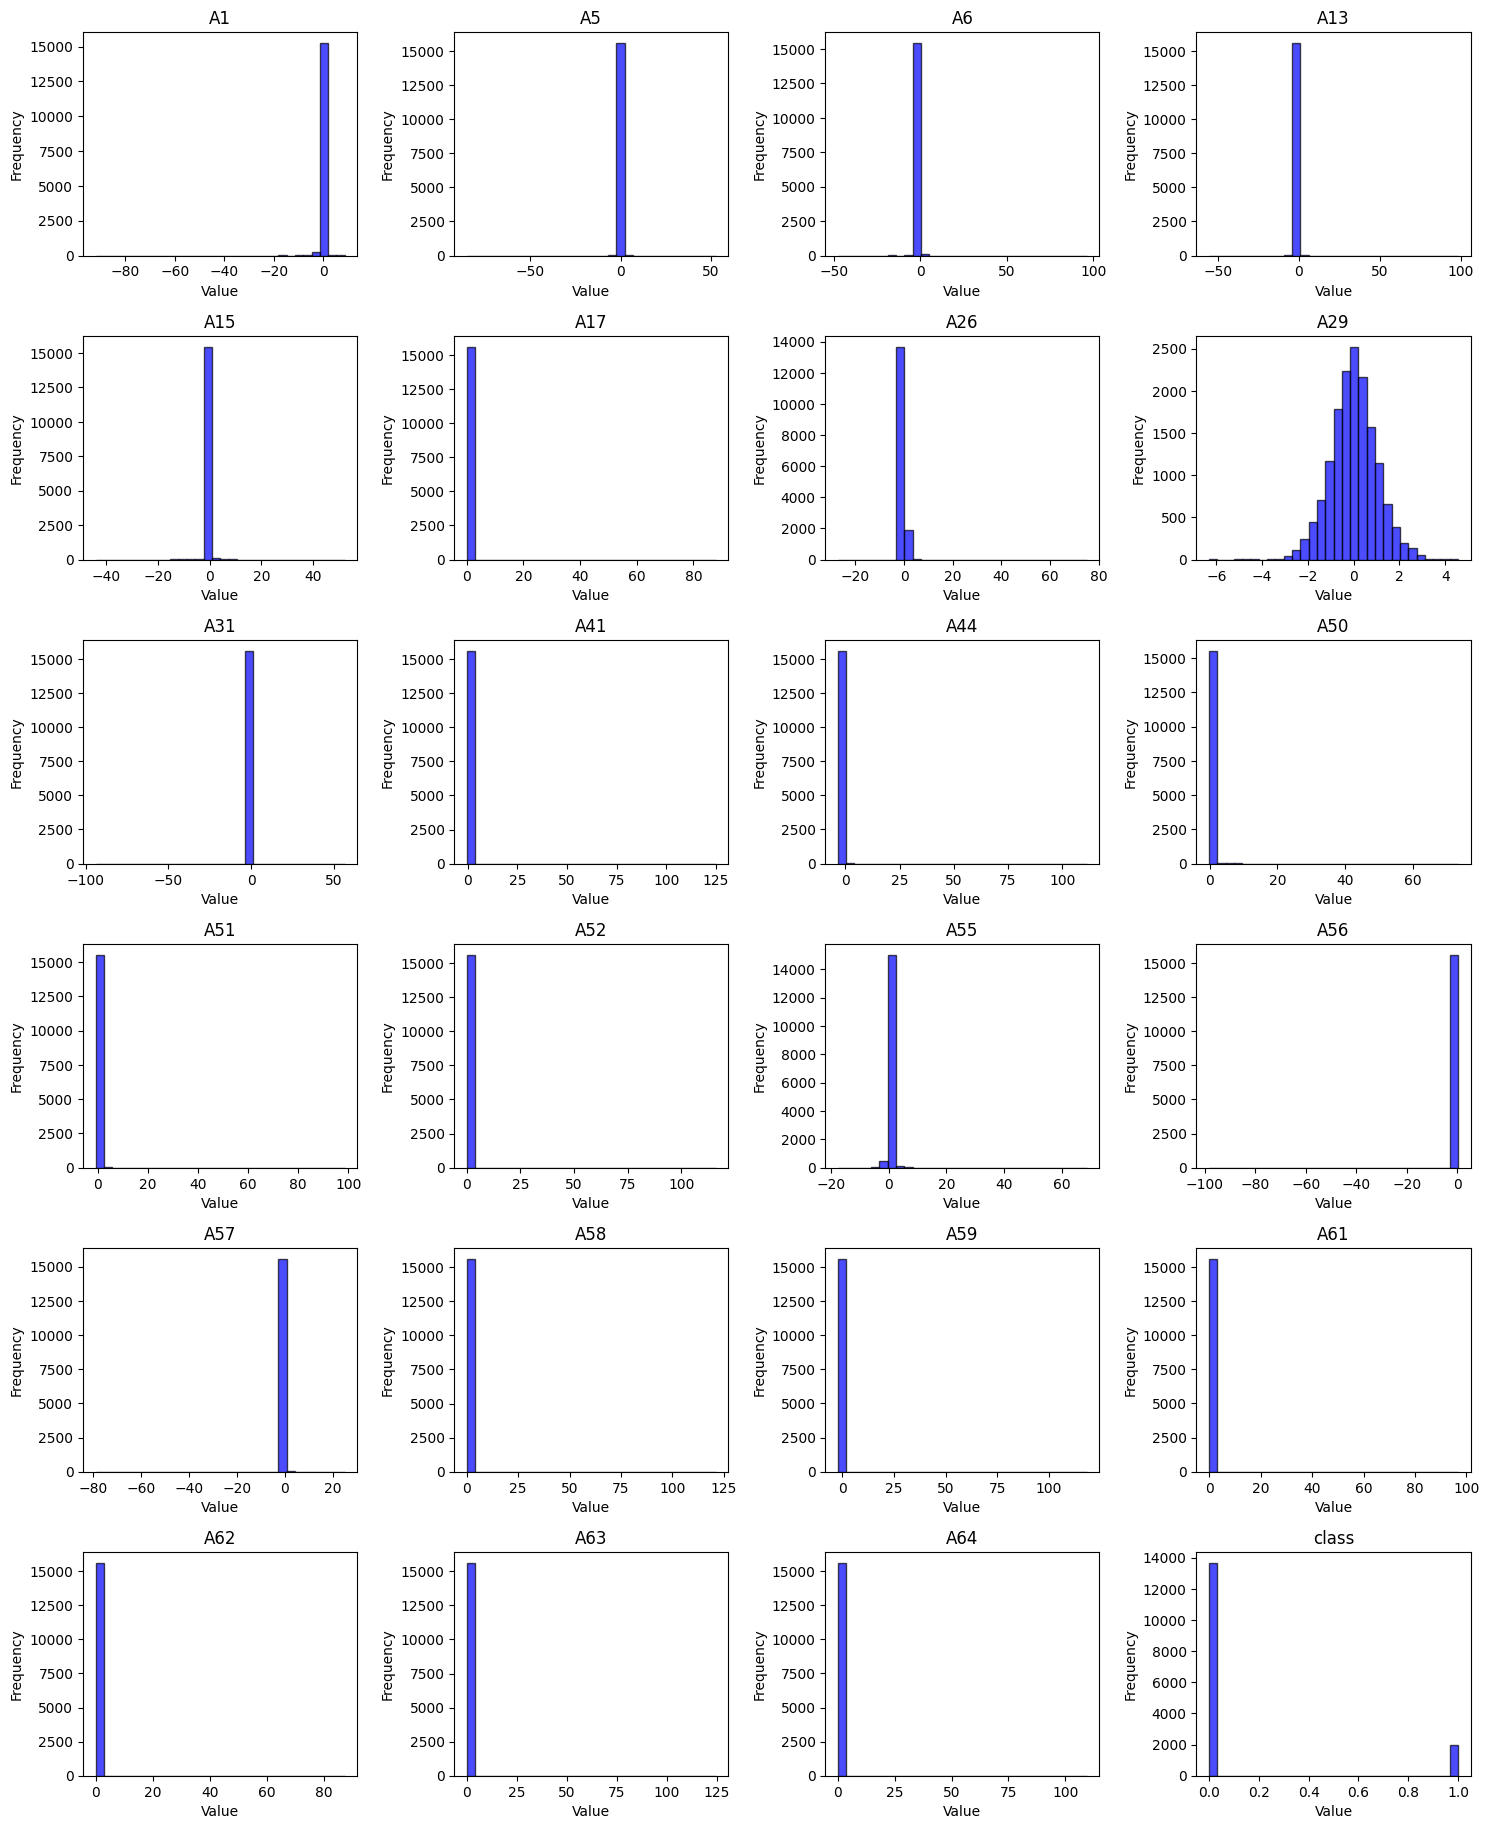

In [ ]:
# Select numerical columns from the scaled dataset
numerical_cols = scaled_dataset.select_dtypes(include=['int64', 'float64']).columns

# Calculate the number of rows needed to plot 4 histograms per row
num_cols = len(numerical_cols)
num_rows = (num_cols // 4) + 1  # Ensures enough rows to fit all plots

# Set figure size based on the number of rows
plt.figure(figsize=(15, num_rows * 3))

# Loop through each numerical column and create a histogram
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(num_rows, 4, i)  # Position the subplot in the grid
    plt.hist(scaled_dataset[col], bins=30, alpha=0.7, color='blue', edgecolor='black')
    plt.title(col)               # Set the title as the column name
    plt.xlabel("Value")          # X-axis label
    plt.ylabel("Frequency")      # Y-axis label

# Adjust spacing to prevent overlap between subplots
plt.tight_layout()
plt.show()


### Visualizing Predictor Variance Before Feature Selection

This cell creates a heatmap to visualize the variance of each predictor in the dataset prior to applying a variance threshold filter. The steps include:

- Dropping the target variable (`class`) to isolate predictors.
- Calculating the variance of each feature.
- Displaying a horizontal heatmap to highlight features with near-zero variance.

This visualization provides a quick diagnostic for identifying low-variance features, which may be uninformative and candidates for removal in subsequent feature selection steps.


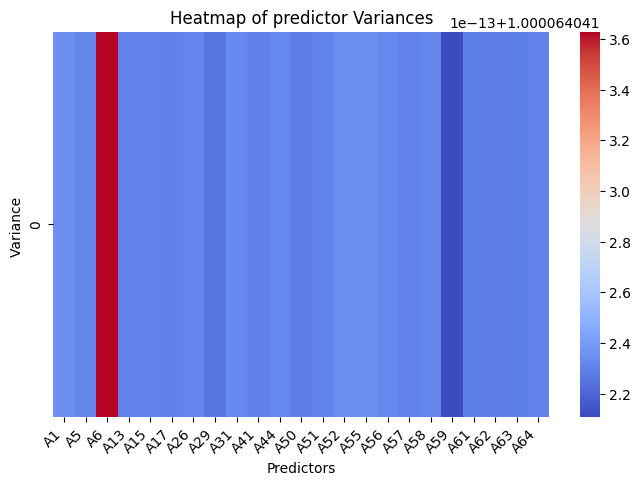

In [ ]:
# near-zero variance
data_no_class = scaled_dataset.drop(columns=['class'], errors='ignore')
plt.figure(figsize=(8, 5))
sns.heatmap(data_no_class.var().to_frame().T, annot=False, cmap='coolwarm')
plt.title('Heatmap of predictor Variances')
plt.xlabel('Predictors')
plt.ylabel('Variance ')
plt.xticks(rotation=45, ha='right')
plt.show()

### Feature Selection Using Low Variance Filter

This cell performs feature selection by removing features with very low variance across observations, which are unlikely to be informative for classification. The steps include:

- Applying `VarianceThreshold` with a threshold of 0.01 to drop features with less than 1% variance.
- Transforming the dataset (`data_no_class`) to retain only high-variance features.
- Printing the names of the retained and removed features for inspection.

This step helps reduce dimensionality and potential noise, improving model training efficiency and generalization.


In [ ]:
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold(threshold=0.01)

# Fit and transform the data
filtered_data = selector.fit_transform(data_no_class)

# Get the remaining feature names
remaining_features = data_no_class.columns[selector.get_support()]
removed_features = data_no_class.columns[~selector.get_support()]
print("Remaining Features:", remaining_features)
print("Removed Features:", removed_features)

Remaining Features: Index(['A1', 'A5', 'A6', 'A13', 'A15', 'A17', 'A26', 'A29', 'A31', 'A41',
       'A44', 'A50', 'A51', 'A52', 'A55', 'A56', 'A57', 'A58', 'A59', 'A61',
       'A62', 'A63', 'A64'],
      dtype='object')
Removed Features: Index([], dtype='object')


### Class Balancing with SMOTE

This cell applies **Synthetic Minority Oversampling Technique (SMOTE)** to balance the dataset, which originally had a significant class imbalance between bankrupt and non-bankrupt companies. The steps include:

- Splitting the dataset into features (`X`) and target variable (`y`)
- Applying `SMOTE` to synthetically generate new instances of the minority class
- Reconstructing a balanced DataFrame (`balanced_df`) with equal class representation
- Printing the new class distribution using `Counter` to verify the balancing outcome

This ensures that subsequent model training is not biased toward the majority class and that models have an equal opportunity to learn from both outcomes.


In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# Split features and target variable
X = reduced_dataset.drop(columns=['class'])
y = reduced_dataset['class']

# Apply SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)  # 'auto' balances to the majority class
X_resampled, y_resampled = smote.fit_resample(X, y)

# Convert back to DataFrame
balanced_df = pd.DataFrame(X_resampled, columns=X.columns)
balanced_df['class'] = y_resampled

# Check new class distribution
print("Class distribution after SMOTE:", Counter(y_resampled))


Class distribution after SMOTE: Counter({0: 13664, 1: 13664})


# Model Training and Evaluation

### Model Training, Hyperparameter Tuning, and Cross-Validation

This cell performs model training and evaluation for six classification models using a consistent machine learning pipeline. The key steps include:

- **Data Split**: The dataset is split into training and test sets using an 80/20 ratio.
- **Pipeline Components**:
  - `StandardScaler` is applied to normalize features.
  - `SMOTE` is used to address class imbalance in the training data.
  - A placeholder model is dynamically set during tuning.

- **Models and Hyperparameter Grids**: Each model is associated with a search space of hyperparameters. `GridSearchCV` is used to find the optimal parameters using 5-fold stratified cross-validation (`StratifiedKFold`).

- **Performance Evaluation**: After tuning, each best model is evaluated again using 5-fold cross-validation. The following metrics are collected and averaged:
  - Precision
  - Recall
  - F1-Score
  - Accuracy
  - Cohen’s Kappa

All results are aggregated into a DataFrame (`results_df`) for comparison across models.


In [ ]:
X = reduced_dataset.drop(columns=['class'])
y = reduced_dataset['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize StratifiedKFold
sKF = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create the scaler and SMOTE
scaler = StandardScaler()
smote = SMOTE(random_state=42)

# Define classifiers and their hyperparameter grids
models = {
    'Logistic Regression': {
        'model': LogisticRegression(),
        'param_grid': {
        }
    },
    'SVM': {
        'model': SVC(),
        'param_grid': {
            'model__C': [1e-3, 1e-2, 1],
            'model__kernel': ['linear', 'rbf']
        }
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(),
        'param_grid': {
            'model__max_depth': [5, 10, 15, None],
            'model__min_samples_split': [2, 5, 10]
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(),
        'param_grid': {
            'model__n_estimators': [50, 100, 200],
            'model__max_depth': [3, 5, 10, None],
            'model__min_samples_split': [2, 5]
        }
    },
    'Gradient Boosting': {
        'model': GradientBoostingClassifier(),
        'param_grid': {
            'model__n_estimators': [50, 100, 200],
            'model__learning_rate': [1e-4, 1e-3, 1e-2],
            'model__max_depth': [3, 5, 7]
        }
    },
    'XGBoost': {
        'model': xgb.XGBClassifier(),
        'param_grid': {
            'model__n_estimators': [50, 100, 200],
            'model__learning_rate': [1e-4, 1e-3, 1e-2],
            'model__max_depth': [3, 5, 7]
        }
    }
}

# Store results
results = []

# Define the pipeline
pipeline = Pipeline([
    ('scaler', scaler),
    ('smote', smote),
    ('model', None)  # Placeholder for model
])

# Iterate over each model and perform GridSearchCV
for model_name, model_info in models.items():
    print(f"Training {model_name}...")

    # Set the model dynamically in the pipeline
    pipeline.set_params(model=model_info['model'])

    # Initialize GridSearchCV for hyperparameter tuning
    grid_search = GridSearchCV(
        estimator = pipeline,
        param_grid=model_info['param_grid'],
        # n_iter=3,
        cv=sKF,
        n_jobs=-1,
        verbose=1,
        # random_state=42,
        scoring='accuracy'
    )

    # Fit the grid search to find the best model
    grid_search.fit(X_train, y_train)

    # Get the best model and the corresponding hyperparameters
    best_model =  grid_search.best_estimator_
    best_params =  grid_search.best_params_

    print(f"Best parameters for {model_name}: {best_model}")
    print(f"Best score for {model_name}: {grid_search.best_score_}")


    # Initialize lists to store performance metrics for each fold
    fold_results = {
        'Precision': [],
        'Recall': [],
        'F1-Score': [],
        'Accuracy': [],
        'Kappa': []
    }

    # Perform cross-validation with the best model
    for train_idx, test_idx in sKF.split(X_train, y_train):
        X_train_cv, X_test_cv = X_train.iloc[train_idx], X_train.iloc[test_idx]
        y_train_cv, y_test_cv = y_train.iloc[train_idx], y_train.iloc[test_idx]

        # Fit the best model
        best_model.fit(X_train_cv, y_train_cv)

        # Predict and evaluate the model
        y_pred = best_model.predict(X_test_cv)

        # Calculate precision, recall, F1-score, and accuracy for each fold
        precision, recall, f1, _ = precision_recall_fscore_support(y_test_cv, y_pred, average='binary')
        accuracy = accuracy_score(y_test_cv, y_pred)
        # Kappa
        kappa = cohen_kappa_score(y_test_cv, y_pred)

        # Append metrics for the current fold
        fold_results['Precision'].append(precision)
        fold_results['Recall'].append(recall)
        fold_results['F1-Score'].append(f1)
        fold_results['Accuracy'].append(accuracy)
        fold_results['Kappa'].append(kappa)

    # Calculate the mean of each metric across all folds
    mean_results = {
        'Model': model_name,
        'Best Params': str(best_params),
        'Precision': np.mean(fold_results['Precision']),
        'Recall': np.mean(fold_results['Recall']),
        'F1-Score': np.mean(fold_results['F1-Score']),
        'Accuracy': np.mean(fold_results['Accuracy']),
        'Kappa': np.mean(fold_results['Kappa'])
    }

    # Append the mean results to the final results list
    results.append(mean_results)

# Convert results to a DataFrame for better readability
results_df = pd.DataFrame(results)
print(results_df)

Training Logistic Regression...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters for Logistic Regression: Pipeline(steps=[('scaler', StandardScaler()), ('smote', SMOTE(random_state=42)),
                ('model', LogisticRegression())])
Best score for Logistic Regression: 0.7014889222302211
Training SVM...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters for SVM: Pipeline(steps=[('scaler', StandardScaler()), ('smote', SMOTE(random_state=42)),
                ('model', SVC(C=0.001))])
Best score for SVM: 0.755364659875159
Training Decision Tree...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters for Decision Tree: Pipeline(steps=[('scaler', StandardScaler()), ('smote', SMOTE(random_state=42)),
                ('model', DecisionTreeClassifier(min_samples_split=5))])
Best score for Decision Tree: 0.7917867547339191
Training Random Forest...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best pa

### Final Model Evaluation on Test Set

This cell evaluates the best-tuned version of each classification model on the test set. The process includes:

- **Retrieving Best Hyperparameters**: For each model, the best hyperparameter configuration is extracted from `results_df` and applied to the model pipeline.
- **Retraining on Full Training Data**: Each model is retrained on the complete (non-SMOTE) training data using its optimized settings.
- **Prediction and Evaluation**: Models are then evaluated on the held-out test set. Performance metrics include:
  - Precision
  - Recall
  - F1-score
  - Accuracy
  - Cohen's Kappa (to account for class agreement beyond chance)

The test performance of all models is compiled into a summary DataFrame (`test_results_df`) and printed for comparison.


In [ ]:
# test models
test_results = []

for model_name, model_info in models.items():
    print(f"Testing {model_name} on test set...")

    # Get the best model for the current model_name
    best_model = results_df.loc[results_df['Model'] == model_name, 'Best Params'].values[0]

    # Convert string representation of parameters back to a dictionary
    best_params = eval(best_model)

    # Set the best model with best parameters
    pipeline.set_params(model=model_info['model'])
    pipeline.set_params(**best_params)

    # Fit the best model on the full training set
    pipeline.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred_test = pipeline.predict(X_test)

    # Evaluate performance on the test set
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_test, average='binary')
    accuracy = accuracy_score(y_test, y_pred_test)
     # Kappa
    kappa = cohen_kappa_score(y_test, y_pred_test)

    # Store test results
    test_results.append({
        'Model': model_name,
        'Precision (Test)': precision,
        'Recall (Test)': recall,
        'F1-Score (Test)': f1,
        'Accuracy (Test)': accuracy,
        'Kappa (Test)': kappa

    })

# Convert test results to a DataFrame
test_results_df = pd.DataFrame(test_results)
print("\nTest Set Results:")
print(test_results_df)

Testing Logistic Regression on test set...
Testing SVM on test set...
Testing Decision Tree on test set...
Testing Random Forest on test set...
Testing Gradient Boosting on test set...
Testing XGBoost on test set...

Test Set Results:
                 Model  Precision (Test)  Recall (Test)  F1-Score (Test)  \
0  Logistic Regression          0.230461       0.600522         0.333092   
1                  SVM          0.244444       0.402089         0.304047   
2        Decision Tree          0.308411       0.516971         0.386341   
3        Random Forest          0.471655       0.543081         0.504854   
4    Gradient Boosting          0.338983       0.731070         0.463193   
5              XGBoost          0.314898       0.728460         0.439716   

   Accuracy (Test)  Kappa (Test)  
0         0.705186      0.189469  
1         0.774328      0.178824  
2         0.798656      0.274997  
3         0.869398      0.430062  
4         0.792254      0.355170  
5         0.772407    

### Train-Test Split, Feature Scaling, and SMOTE Balancing

This cell prepares the data for model training and evaluation through the following steps:

- **Train-Test Split**: The dataset is split into training (80%) and testing (20%) subsets using stratified sampling to preserve class balance across splits.
- **Feature Scaling**: A `StandardScaler` is applied to normalize the features, ensuring zero mean and unit variance. The scaler is fitted on the training data and applied to both training and test sets.
- **Class Balancing with SMOTE**: Synthetic Minority Oversampling Technique (SMOTE) is used to balance the training set by generating synthetic examples of the minority (bankrupt) class.

The shapes of the resulting datasets are printed to confirm proper splitting, scaling, and resampling.


In [ ]:
X = reduced_dataset.drop(columns=['class'])
y = reduced_dataset['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# Create the scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# smote
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

print(X_train_scaled.shape)
print(y_train.shape)
print(X_test_scaled.shape)
print(y_test.shape)

(12492, 23)
(12492,)
(3124, 23)
(3124,)


### Hyperparameter Tuning with Keras Tuner

This cell defines and performs hyperparameter optimization for the ANN model using the Keras Tuner library. The process includes:

- **Model Search Space**: The tuner searches over:
  - Number of hidden layers (1–5)
  - Units per layer (64, 128, or 256)
  - Dropout rate (0.2 or 0.3)
  - Learning rate (sampled log-uniformly between $1\mathrm{e}{-5}$ and $1\mathrm{e}{-3}$)

- **Model Construction**: A flexible model-building function (`call_existing_code`) constructs models based on the sampled hyperparameters.

- **Search Strategy**: Random search is used to explore the hyperparameter space with:
  - `max_trials=5` (maximum configurations to test)
  - `executions_per_trial=3` (each configuration is trained 3 times)
  - `val_accuracy` as the optimization objective

- **Training Setup**: Models are trained on the SMOTE-balanced training set with an 80/20 training-validation split and early stopping to prevent overfitting.

The best model and its corresponding hyperparameters are printed and summarized after the search.


In [ ]:
# existing code for model building with variable layers and dropout rate
def call_existing_code(units_per_layer, dropout_rate,lr):
    model = Sequential()
    # tune number of units separately
    for units in units_per_layer:
        # model.add(layers.Dense(units=units, activation='relu',kernel_regularizer=regularizers.l2(l2_rate)))
        model.add(layers.Dense(units=units, activation='relu'))
        # tune whether to use dropout
        if dropout_rate:
            model.add(layers.Dropout(rate=dropout_rate))

    model.add(layers.Dense(1, activation="sigmoid"))
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss='binary_crossentropy',
        metrics=["accuracy"],
    )
    return model

# Define the model builder function for the tuner
def build_model(hp):
    input_shape = (X_train_scaled.shape[1],)
    num_layers = hp.Int("num_layers", min_value=1, max_value=5)
    units_per_layer = [hp.Choice(f"units_layer{i}", [64,128,256]) for i in range(num_layers)]
    # activation = hp.Choice("activation", ["relu", "tanh"])
    dropout_rate = hp.Choice("dropout_rate", [0.2, 0.3])
    # dropout_rate = hp.Float("dropout_rate", min_value=0.1, max_value=0.5, step=0.05)
    lr = hp.Float("lr", min_value=1e-5, max_value=1e-3, sampling="log")
    # l2_rate = hp.Float("l2_rate", min_value=1e-7, max_value=1e-3, sampling="log")

    # Call existing model-building code with the hyperparameter values
    # model = call_existing_code(units_per_layer=units_per_layer, dropout_rate=dropout_rate, lr=lr, l2_rate=l2_rate)
    model = call_existing_code(units_per_layer=units_per_layer, dropout_rate=dropout_rate, lr=lr)

    return model

# Example usage with keras-tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=3,
    overwrite=True,
    directory='/content/drive/Shareddrives/CS5831 Data Mining Spring 2025',
    project_name='Test'
)

early_stopping = EarlyStopping(monitor='val_accuracy', patience=12, mode='max')

tuner.search(X_train_smote, y_train_smote, epochs=200, validation_split=0.2, callbacks=[early_stopping])
# best_model = tuner.get_best_models(num_models=1)[0]

# Get the top 2 models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]
best_model.build(input_shape=(None, X_train_scaled.shape[1]))
best_model.summary()
# To get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# plot(history)
# the optimal l2 rate is {best_hps.get('l2_rate')},

print(f"""
The hyperparameter search is complete. The optimal number of layers is {best_hps.get('num_layers')},
whether to use dropout is {best_hps.get('dropout_rate')},
and the optimal learning rate for the optimizer is {best_hps.get('lr')}.
""")

### Artificial Neural Network (ANN) Architecture

This cell defines the architecture for the Artificial Neural Network (ANN) used throughout the study. The model is built using the Keras Functional API and includes the following components:

- **Input Layer**: Accepts input features equal to the number of scaled predictors.
- **Hidden Layers**: Four fully connected (`Dense`) layers with ReLU activation. The first two layers have 256 units, followed by two layers with 64 units each.
- **Dropout Layers**: A dropout rate of 0.3 is applied after each dense layer to reduce overfitting and encourage generalization.
- **Output Layer**: A single neuron with sigmoid activation for binary classification (bankrupt vs. non-bankrupt).

This architecture is designed to balance model capacity and regularization, and is used as the base model for all training and cross-validation experiments.


In [ ]:
# ANN
def ANN():
    M1_input = Input(shape=(X_train_scaled.shape[1],))
    M1_dense_1 = Dense(256)(M1_input)
    drop_out = Dropout(0.3)(M1_dense_1)

    M1_dense_2 = Dense(256, activation='relu')(drop_out)
    drop_out = Dropout(0.3)(M1_dense_2)

    M1_dense_3 = Dense(64, activation='relu')(drop_out)
    drop_out = Dropout(0.3)(M1_dense_3)

    M1_dense_4 = Dense(64, activation='relu')(drop_out)
    drop_out = Dropout(0.3)(M1_dense_4)

    # M1_dense_5 = Dense(128, activation='relu')(drop_out)
    # drop_out = Dropout(0.3)(M1_dense_5)

    M1_output = Dense(1, activation='sigmoid')(drop_out)

    model = Model(inputs=M1_input, outputs=M1_output)

    return model

### Plotting Training and Validation Curves

This function visualizes the training process of the ANN by plotting learning curves for both accuracy and loss over epochs. It displays:

- **Training vs. Validation Accuracy**: to assess how well the model is generalizing.
- **Training vs. Validation Loss**: to detect overfitting or underfitting.

These plots provide insight into model convergence and help guide hyperparameter adjustments.


In [ ]:
def plot(history):
    # learning curves of model accuracy
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.show()

### 5-Fold Cross-Validation with ANN and SMOTE

This cell performs stratified 5-fold cross-validation to evaluate the performance of an Artificial Neural Network (ANN) model using resampled training data. The key steps include:

- **StratifiedKFold** ensures that each fold maintains the original class distribution.
- **SMOTE** is applied to the training portion of each fold to synthetically balance the classes.
- **Class weights** are computed for the resampled data to further handle class imbalance during model training.
- The ANN is compiled using the Adam optimizer and binary cross-entropy loss.
- **EarlyStopping** monitors validation accuracy with a patience of 10 epochs to prevent overfitting.

For each fold:
- The model is trained on the SMOTE-balanced data and validated on the held-out fold.
- A custom threshold for classification is chosen by maximizing the F1-score from the precision-recall curve.
- A suite of evaluation metrics is calculated, including Cohen’s kappa, accuracy, precision, recall, F1-score, specificity, AUROC, AUPR, and Matthews correlation coefficient.
- The confusion matrix and performance metrics are printed, and training history is visualized.
- Results for each fold are stored in a summary DataFrame (`df_ann`) for further analysis.

Epoch 1/80
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7671 - loss: 0.6246 - val_accuracy: 0.8747 - val_loss: 0.4120
Epoch 2/80
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8751 - loss: 0.4068 - val_accuracy: 0.8752 - val_loss: 0.3490
Epoch 3/80
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8786 - loss: 0.3578 - val_accuracy: 0.8747 - val_loss: 0.3351
Epoch 4/80
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8726 - loss: 0.3609 - val_accuracy: 0.8756 - val_loss: 0.3303
Epoch 5/80
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8729 - loss: 0.3655 - val_accuracy: 0.8760 - val_loss: 0.3287
Epoch 6/80
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8785 - loss: 0.3492 - val_accuracy: 0.8764 - val_loss: 0.3277
Epoch 7/80
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8747 - loss: 0.3475 - val_accuracy: 0.8760 - val_loss: 0.3270
Epoch 8/80
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8770 - loss: 0.3442 - val_accuracy: 0.

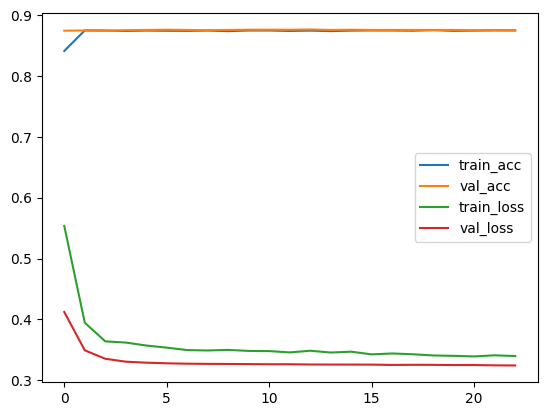

Kappa  : 0.28
Accuracy  : 0.74
Precision : 0.28
Recall    : 0.73
F1 Score  : 0.41
MCC       : 0.33
Specificity: 0.74
AUROC     : 0.77
AUPR      : 0.33

Confusion Matrix:
              Predicted No     Predicted Yes
Actual No       1614               572
Actual Yes        86               227
Epoch 1/80
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.6612 - loss: 0.6625 - val_accuracy: 0.8747 - val_loss: 0.4502
Epoch 2/80
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8724 - loss: 0.4350 - val_accuracy: 0.8747 - val_loss: 0.3565
Epoch 3/80
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8716 - loss: 0.3803 - val_accuracy: 0.8743 - val_loss: 0.3487
Epoch 4/80
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8695 - loss: 0.3685 - val_accuracy: 0.8739 - val_loss: 0.3452
Epoch 5/80
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8777 - loss: 0.3500 - val_accuracy: 0.8727 - val_loss: 0.3437
Epoch 6/80
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8

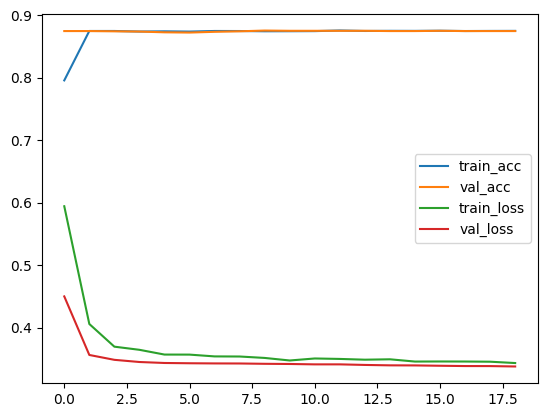

Kappa  : 0.23
Accuracy  : 0.74
Precision : 0.26
Recall    : 0.59
F1 Score  : 0.36
MCC       : 0.26
Specificity: 0.76
AUROC     : 0.74
AUPR      : 0.30

Confusion Matrix:
              Predicted No     Predicted Yes
Actual No       1655               531
Actual Yes       127               186
Epoch 1/80
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.6952 - loss: 0.6520 - val_accuracy: 0.8751 - val_loss: 0.4360
Epoch 2/80
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.8743 - loss: 0.4156 - val_accuracy: 0.8747 - val_loss: 0.3631
Epoch 3/80
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8740 - loss: 0.3716 - val_accuracy: 0.8731 - val_loss: 0.3493
Epoch 4/80
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8686 - loss: 0.3711 - val_accuracy: 0.8755 - val_loss: 0.3441
Epoch 5/80
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8699 - loss: 0.3692 - val_accuracy: 0.8743 - val_loss: 0.3415
Epoch 6/80
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8

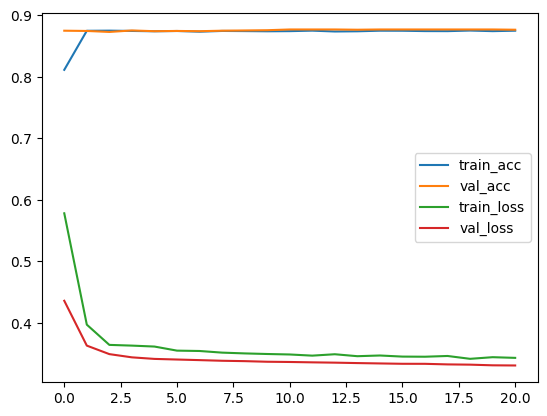

Kappa  : 0.24
Accuracy  : 0.76
Precision : 0.27
Recall    : 0.55
F1 Score  : 0.37
MCC       : 0.26
Specificity: 0.79
AUROC     : 0.75
AUPR      : 0.31

Confusion Matrix:
              Predicted No     Predicted Yes
Actual No       1731               455
Actual Yes       140               172
Epoch 1/80
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7823 - loss: 0.6215 - val_accuracy: 0.8751 - val_loss: 0.4165
Epoch 2/80
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8794 - loss: 0.4017 - val_accuracy: 0.8755 - val_loss: 0.3498
Epoch 3/80
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8718 - loss: 0.3719 - val_accuracy: 0.8763 - val_loss: 0.3354
Epoch 4/80
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8733 - loss: 0.3665 - val_accuracy: 0.8763 - val_loss: 0.3306
Epoch 5/80
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8756 - loss: 0.3523 - val_accuracy: 0.8763 - val_loss: 0.3285
Epoch 6/80
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8

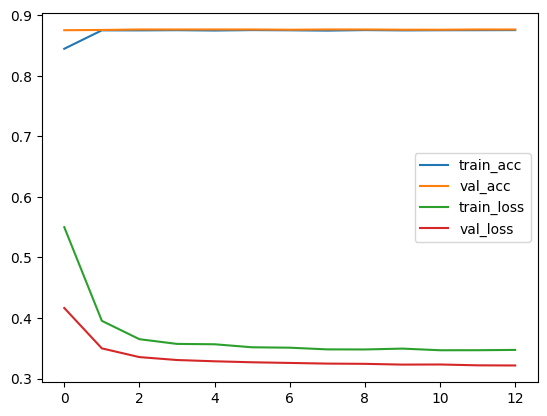

Kappa  : 0.27
Accuracy  : 0.79
Precision : 0.30
Recall    : 0.55
F1 Score  : 0.39
MCC       : 0.29
Specificity: 0.82
AUROC     : 0.77
AUPR      : 0.35

Confusion Matrix:
              Predicted No     Predicted Yes
Actual No       1790               396
Actual Yes       141               171
Epoch 1/80
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5159 - loss: 0.7087 - val_accuracy: 0.8751 - val_loss: 0.4942
Epoch 2/80
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8778 - loss: 0.4556 - val_accuracy: 0.8751 - val_loss: 0.3660
Epoch 3/80
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8713 - loss: 0.3717 - val_accuracy: 0.8759 - val_loss: 0.3560
Epoch 4/80
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8747 - loss: 0.3531 - val_accuracy: 0.8755 - val_loss: 0.3529
Epoch 5/80
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8722 - loss: 0.3598 - val_accuracy: 0.8751 - val_loss: 0.3515
Epoch 6/80
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8

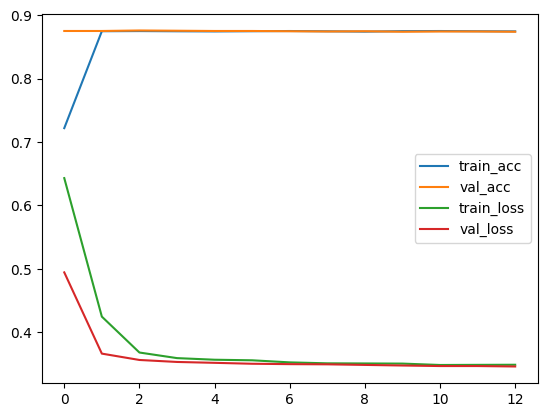

Kappa  : 0.20
Accuracy  : 0.69
Precision : 0.24
Recall    : 0.66
F1 Score  : 0.35
MCC       : 0.25
Specificity: 0.70
AUROC     : 0.72
AUPR      : 0.26

Confusion Matrix:
              Predicted No     Predicted Yes
Actual No       1525               661
Actual Yes       105               207


In [ ]:
# Initialize KFold
sKF = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold = 1
ann_scores=[]
for train, val in sKF.split(X_train_scaled,y_train):

    X_train_pt, X_val_pt = X_train_scaled[train], X_train_scaled[val]
    y_train_pt, y_val = y_train.iloc[train], y_train.iloc[val]
    # Apply SMOTE to the training data only
    X_train_smote, y_train_smote = smote.fit_resample(X_train_pt, y_train_pt)
    # Compute class weights for the resampled data
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train_smote),
        y=y_train_smote
    )
    class_weight_dict = dict(zip(np.unique(y_train_smote), class_weights))

    model = ANN()
    model.compile(optimizer=Adam(learning_rate=5e-05 ),
              loss=BinaryCrossentropy(),
              metrics=['accuracy'])

    metric = 'val_accuracy'

    es = EarlyStopping(monitor='val_accuracy', patience=10, mode='max')

    # Training and Evaluation
    history = model.fit(X_train_scaled, y_train, epochs=80, verbose=1,
                        class_weight=class_weight_dict,
                        validation_data = (X_val_pt, y_val), callbacks=[es])

   # After predicting probabilities
    y_pred_prob = model.predict(X_val_pt).reshape(-1)

    # === Find best threshold ===
    precision_vals, recall_vals, thresholds = precision_recall_curve(y_val, y_pred_prob)
    f1_scores = 2 * (precision_vals * recall_vals) / (precision_vals + recall_vals + 1e-8)
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx]

    print(f"Best threshold for F1: {best_threshold:.2f}")

    # Predict using the optimized threshold
    y_pred = (y_pred_prob >= best_threshold).astype(int)
    y_val = np.array(y_val)
    y_pred = np.array(y_pred)

    # calculate metrics
    kappa = cohen_kappa_score(y_val, y_pred)
    accuracy = accuracy_score(y_val,y_pred)
    precision = precision_score(y_val,y_pred)
    recall = recall_score(y_val,y_pred)
    f1 = f1_score(y_val,y_pred)
    mcc = matthews_corrcoef(y_val,y_pred)
    cm = confusion_matrix (y_val,y_pred)
    tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
    specificity = tn / (tn+fp)
    # binary classification roc
    auroc = roc_auc_score(y_val,y_pred_prob)
    aupr = average_precision_score(y_val,y_pred_prob)
    # append results
    ann_scores.append((fold,recall,specificity,accuracy,precision,f1,auroc,aupr,mcc))
    plot(history)
    #
    # Print the metrics in a readable format
    print(f"Kappa  : {kappa:.2f}")
    print(f"Accuracy  : {accuracy:.2f}")
    print(f"Precision : {precision:.2f}")
    print(f"Recall    : {recall:.2f}")
    print(f"F1 Score  : {f1:.2f}")
    print(f"MCC       : {mcc:.2f}")
    print(f"Specificity: {specificity:.2f}")
    print(f"AUROC     : {auroc:.2f}")
    print(f"AUPR      : {aupr:.2f}")

    # Print confusion matrix
    print("\nConfusion Matrix:")
    print(f"              Predicted No     Predicted Yes")
    print(f"Actual No     {cm[0][0]:>6}            {cm[0][1]:>6}")
    print(f"Actual Yes    {cm[1][0]:>6}            {cm[1][1]:>6}")
    # print("\n %s, %s, %s, %s, %s \n" %(str(acc), str(mcc), str(sn), str(sp), cm))
    fold += 1

cols = ['Fold','Sensitivity', 'Specificity','Accuracy','Precision','F1 Score','AUC-ROC','AUC-PR','MCC']
df_ann = pd.DataFrame(ann_scores, columns=cols)

### Final Training on Full Balanced Dataset (ANN)

This cell trains the Artificial Neural Network (ANN) model using the fully balanced dataset produced by SMOTE. The model is compiled with:

- **Adam optimizer** with a low learning rate (`5e-5`) for stable convergence,
- **Binary cross-entropy loss**, suitable for binary classification tasks,
- **Accuracy** as the primary evaluation metric.

An **early stopping** callback monitors training accuracy and halts training if performance does not improve over 8 consecutive epochs, helping prevent overfitting. The model is trained for up to 70 epochs with a batch size of 32.

In [ ]:
# train on the whole dataset
model = ANN()
model.compile(optimizer=Adam(learning_rate=5e-5),
          loss=BinaryCrossentropy(),
          metrics=['accuracy'])

metric = 'accuracy'

es = EarlyStopping(monitor='accuracy', patience=8, mode='max')

# Training and Evaluation
model.fit(X_train_smote, y_train_smote, batch_size=32, epochs=70, verbose=1, callbacks=[es])

Epoch 1/70
547/547 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - accuracy: 0.5674 - loss: 0.6917
Epoch 2/70
547/547 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6598 - loss: 0.6447
Epoch 3/70
547/547 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6787 - loss: 0.6196
Epoch 4/70
547/547 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6779 - loss: 0.6138
Epoch 5/70
547/547 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6824 - loss: 0.6063
Epoch 6/70
547/547 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6776 - loss: 0.6055
Epoch 7/70
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6829 - loss: 0.6025
Epoch 8/70
547/547 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6836 - loss: 0.5988
Epoch 9/70
547/547 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6931 - loss: 0.5916
Epoch 10/70
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6817 - loss: 0.5987
Epoch 11/70
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6860 - loss: 0.5943
Epoch 12/70
547/547 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/ste

### Model Evaluation on Test Set

This cell evaluates the final trained model on the test set. It begins by generating probability predictions and finding the optimal classification threshold based on the maximum F1-score from the precision-recall curve. Using this threshold, binary predictions are generated and a suite of performance metrics is calculated, including:

- **Cohen's Kappa**: Measures agreement between predicted and true labels, adjusted for chance.
- **Accuracy, Precision, Recall, and F1-Score**: Standard classification metrics.
- **Matthews Correlation Coefficient (MCC)**: A balanced measure even for imbalanced datasets.
- **Specificity**: True negative rate.
- **AUROC and AUPR**: Area under the ROC and precision-recall curves, respectively.


In [ ]:
# test on testset
y_pred_prob = model.predict(X_test_scaled).reshape(-1)

# === Find best threshold ===
precision_vals, recall_vals, thresholds = precision_recall_curve(y_test, y_pred_prob)
f1_scores = 2 * (precision_vals * recall_vals) / (precision_vals + recall_vals + 1e-8)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
# Predict using the optimized threshold
y_pred = (y_pred_prob >= best_threshold).astype(int)

print(f"Best threshold for F1: {best_threshold:.2f}")

# Evaluate the best model
kappa = cohen_kappa_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
cm = confusion_matrix (y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity = tn / (tn+fp)
auroc = roc_auc_score(y_test, y_pred_prob)
aupr = average_precision_score(y_test, y_pred_prob)

# Print the metrics in a readable format
print(f"Kappa  : {kappa:.2f}")
print(f"Accuracy  : {accuracy:.2f}")
print(f"Precision : {precision:.2f}")
print(f"Recall    : {recall:.2f}")
print(f"F1 Score  : {f1:.2f}")
print(f"MCC       : {mcc:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"AUROC     : {auroc:.2f}")
print(f"AUPR      : {aupr:.2f}")

# Print confusion matrix
print("\nConfusion Matrix:")
print(f"              Predicted No     Predicted Yes")
print(f"Actual No     {cm[0][0]:>6}            {cm[0][1]:>6}")
print(f"Actual Yes    {cm[1][0]:>6}            {cm[1][1]:>6}")

# store metrics for data frmae
ann_scores=[]
ann_scores.append((recall,specificity,kappa,accuracy,precision,f1,auroc,aupr,mcc))
# create dataframe
cols = ['Sensitivity', 'Specificity','Kappa','Accuracy','Precision','F1 Score','AUC-ROC','AUC-PR','MCC']
df_ann = pd.DataFrame(ann_scores, columns=cols)
df_ann

98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Best threshold for F1: 0.61
Kappa  : 0.26
Accuracy  : 0.75
Precision : 0.28
Recall    : 0.62
F1 Score  : 0.39
MCC       : 0.29
Specificity: 0.77
AUROC     : 0.77
AUPR      : 0.30

Confusion Matrix:
              Predicted No     Predicted Yes
Actual No       2115               619
Actual Yes       149               241


,Sensitivity,Specificity,Kappa,Accuracy,Precision,F1 Score,AUC-ROC,AUC-PR,MCC
0,0.617949,0.773592,0.258168,0.754161,0.280233,0.3856,0.769561,0.301247,0.289748
